In [2]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

jax.config.update("jax_enable_x64", True)

try:
    import tinygp
except ModuleNotFoundError:
    %pip install -qqq tinygp
    import tinygp

kernels = tinygp.kernels
from tinygp.helpers import dataclass, field, JAXArray
from tinygp import GaussianProcess

In [3]:
latexify(width_scale_factor=1, fig_height=2)

/home/patel_zeel/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## ARD kernel

Inspired from Equation 5.2 (M3)

In [4]:
@dataclass
class RBF(kernels.Kernel):
    Lambda: JAXArray = field(default_factory=lambda: jnp.eye(2))
    lengthscale_inv: JAXArray = field(default_factory=lambda: jnp.array([0.0, 0.0]))

    def evaluate(self, x1, x2):
        lengthscale_covar = self.Lambda @ self.Lambda.T + jnp.diag(self.lengthscale_inv) ** 2
        dist = jnp.dot((x1 - x2).reshape(1, -1), jnp.dot(lengthscale_covar, (x1 - x2).reshape(-1, 1)))
        #         print(jnp.exp(-0.5 * dist).ravel().shape)
        return jnp.exp(-0.5 * dist)[0, 0]

In [9]:
def plot_surface(data, save_name=""):
    figsize = None if is_latexify_enabled() else (12, 7)
    fig, ax = plt.subplots(1, len(data), figsize=figsize, subplot_kw={"projection": "3d"})
    ax = [ax] if len(data) == 1 else ax
    ax[0].set_zlabel(
        "output $y$",
        labelpad=-1,
    )
    for index, entry in enumerate(data):
        Lambda, lengthscale_inv = entry["Lambda"], entry["lengthscale_inv"]
        kernel = RBF(Lambda, lengthscale_inv)
        gp = GaussianProcess(kernel, x)
        y = gp.sample(key).reshape(N, N)

        mappable = ax[index].plot_surface(x1, x2, y, lw=0.5, cmap="viridis")
        ax[index].set_xlabel("input $x_1$", labelpad=-1)
        ax[index].view_init(None, 180 + 50)
        ax[index].set_zlim(-1.0, 2.0)
        ax[index].set_zticks(range(-1, 3))
        ax[index].set_zticklabels([])
        ax[index].set_ylabel("input $x_2$", labelpad=-1)
    ax[index].set_zticklabels(range(-1, 3))
    fig.colorbar(mappable)
    if len(save_name) > 0:
        savefig(save_name, bbox_inches="tight")  # Use 'tight' only when necessary (3d plots)

In [10]:
r = jnp.arange(-3, 3.1, 0.1)
N = len(r)
x1, x2 = jnp.meshgrid(r, r)
x = jnp.array([(i, j) for i, j in zip(x1.ravel(), x2.ravel())])
key = jax.random.PRNGKey(4)

/home/patel_zeel/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


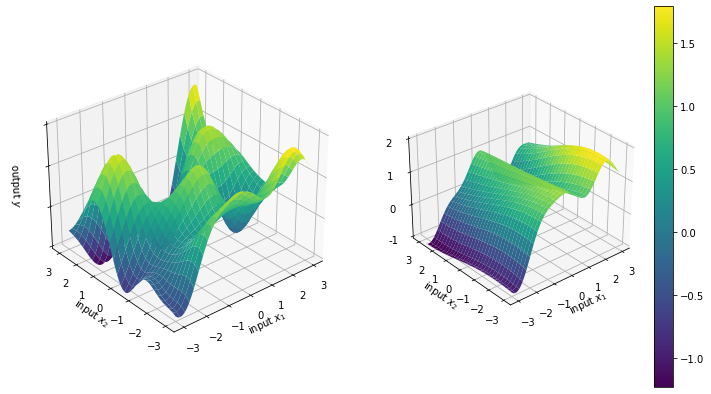

In [11]:
data = [
    {"Lambda": jnp.eye(2), "lengthscale_inv": jnp.array([0.0, 0.0])},
    {"Lambda": jnp.array([[1.0, 0.0], [0.0, 1 / 5.0]]), "lengthscale_inv": jnp.array([0.0, 0.0])},
    #         {"Lambda": jnp.array([[1.0, -1.0]]).reshape(2,1), "lengthscale_inv": 1.0/jnp.array([6.0, 6.0])}
]
plot_surface(data, save_name="gpDemoArd.pdf")

## Demo

In [12]:
from ipywidgets import interact


@interact(
    Lambda_11=(0.01, 5.00),
    Lambda_12=(0.01, 5.00),
    Lambda_21=(0.01, 5.00),
    Lambda_22=(0.01, 5.00),
    lengthscale__inv1=(0.01, 5.00),
    lengthscale__inv2=(0.01, 5.00),
)
def interactive_plot(
    Lambda_11=1, Lambda_12=0, Lambda_21=0, Lambda_22=1, lengthscale__inv1=0.01, lengthscale__inv2=0.01
):
    data = [
        {
            "Lambda": jnp.array([[Lambda_11, Lambda_12], [Lambda_21, Lambda_22]]),
            "lengthscale_inv": jnp.array([lengthscale__inv1, lengthscale__inv2]),
        }
    ]
    plot_surface(data)

interactive(children=(FloatSlider(value=1.0, description='Lambda_11', max=5.0, min=0.01), FloatSlider(value=0.…